
# **Practice 2 - Leaky Integrate-and-Fire Neuron Model and SNN Inference**
## Sep. 2024
This file is a modification of snnTorch tutorial written by Jason K. Eshraghian.



# Introduction
In this tutorial, you will:
* Learn how the leaky integrate-and-fire (LIF) neuron works
* Implement a feedforward spiking neural network (SNN) using LIF neuron



In [1]:
#Install snnTorch
!pip install snntorch

DEPRECATION: pytorch-lightning 1.6.1 has a non-standard dependency specifier torch>=1.8.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
# imports
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
device

device(type='cuda')

In [3]:
#@title Plotting Settings
import numpy as np
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False, ylim_max1=1.25, ylim_max2=1.25):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [0.4, 1, 0.4]})


  ax[0].bar(np.arange(len(cur)),cur, width=0.2)
  ax[0].set_ylim([0, ylim_max1])


  ax[0].set_ylabel("Integrated Input\n($\sum_i W_iS_i[t]$)")
  if title:
    ax[0].set_title(title)

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes ($S[t]$)")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

# 1. Leaky Integrate-and-Fire Neuron Model

Input Integration:
$$U[t] = \underbrace{\beta U[t-1]}_\text{decay} + \underbrace{\sum_i W_iS_i[t]}_\text{input} \tag{1}$$

Spike Generation:
$$S[t] = \begin{cases} 1, &\text{if}~U[t] > U_{\rm thr} \\
0, &\text{otherwise}\end{cases} \tag{2}$$

Reset-by-subtraction:
$$U[t] = U[t] - \underbrace{S[t]U_{thr}}_\text{reset} \tag{3}$$



# 2. `Leaky` Neuron Model in snnTorch

An almost identical neuron can be achieved by instantiating `snn.Leaky`.



Run a quick simulation to check the neuron behaves correctly in response to a **randomly generated integrated-input** sequence

In [4]:
lif1 = snn.Leaky(beta=0.8)

The neuron model is now stored in `lif1`. To use this neuron:

**Inputs**
* `input[t]`: each element of $\sum_i W_i\times S_i[t]$ is sequentially passed as an input
* `mem`: the previous step membrane potential, $U[t-1]$, is also passed as input.

**Outputs**
* `spk_out`: output spike $S[t]$ ('1' if there is a spike; '0' if there is no spike)
* `mem`: membrane potential $U[t]$ of the present step

These all need to be of type `torch.Tensor`. Note that here, we assume the input has already been **weighted** before passing into the `snn.Leaky` neuron. This will make more sense when we construct a network-scale model.

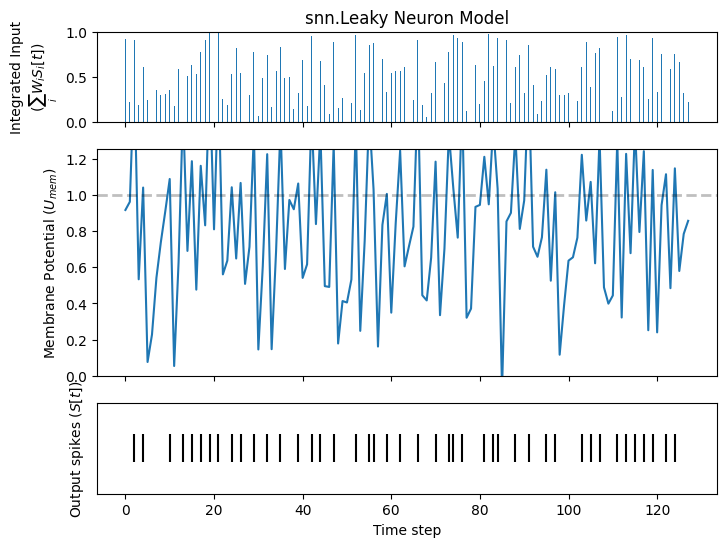

In [5]:

num_steps = 128

# Initialize input & mem & output spikes
input = torch.rand(num_steps)
mem = torch.zeros(1)
spk = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  spk, mem = lif1(input[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(input, mem_rec, spk_rec, thr_line=1, ylim_max1=1,
                 title="snn.Leaky Neuron Model")

# 3. A Feedforward Spiking Neural Network

So far, we have only considered how a single neuron responds to input stimulus. snnTorch makes it straightforward to scale this up to a deep neural network. In this section, we will create a 3-layer fully-connected neural network of dimensions 784-1000-10. Compared to our simulations so far, each neuron will now integrate over many more incoming input spikes.


<center>
<img src='https://github.com/jeshraghian/snntorch/blob/master/docs/_static/img/examples/tutorial2/2_8_fcn.png?raw=true' width="600">
</center>

**PyTorch** is used to form the **connections** between neurons, and **snnTorch** to create the **neurons**. An intuitive way to think about how PyTorch and snnTorch work together is that PyTorch routes the neurons together, and snnTorch loads the results into spiking neuron models. In terms of coding up a network, these spiking neurons can be treated like **time-varying activation functions**.

Here is a sequential account of what's going on:

*  The $i^{th}$ input from `spk_in` to the $j^{th}$ neuron is weighted by the parameters initialized in `nn.Linear`: $S_{i} \times W_{ij}$
* This generates the input term from Equation $(1)$, contributing to $U[t]$ of the spiking neuron
* If $U[t] > U_{\rm thr}$, then a spike is triggered from this neuron
* This spike is weighted by the second layer weight, and the above process is repeated for all inputs, weights, and neurons.
* If there is no spike, then nothing is passed to the post-synaptic neuron.



In abstract, the **key** **differences** between **ANN** and **SNN** are:

1.   Use `snn.Leaky` instead of activation function (e.g., `nn,ReLU`)
2.   Iterate feedforward over `num_steps`

Also, we need to initialize the hidden variables and outputs of each spiking neuron.
As networks increase in size, this becomes more tedious. The static method `init_leaky()` can be used to take care of this. All neurons in snnTorch have their own initialization methods. The shape of the hidden states are automatically initialized based on the input data dimensions during the first forward pass.


<center>
<img src='https://github.com/kimbss470/content/blob/master/img5.png?raw=true' width="1000">
</center>

In [6]:
# layer parameters
num_inputs = 784
num_hidden = 1000
num_outputs = 10
beta = 0.99
num_steps = 200

# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the hidden & final layer
        spk1_rec = []
        spk2_rec = []
        mem2_rec = []
        
        for step in range(num_steps):
            cur1 = self.fc1(x[step])                    # integrate input (sum of (X_i*S_i[t]))
            spk1, mem1 = self.lif1(cur1, mem1)          # generate spike & reset mem
            spk1_rec.append(spk1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

# Load the network onto CUDA if available
net = Net().to(device)

Create an input spike train to pass to the network. There are 200 time steps to simulate across 784 input neurons. Neural nets typically process data in minibatches. snnTorch uses time-first dimensionality:

[$time \times batch\_size \times feature\_dimensions$]. The dimensions of this input tensor must be 200 $\times$ 1 $\times$ 784:

In [7]:
spk_in = spikegen.rate(torch.rand((1, 784)), num_steps=num_steps)
print(f"Dimensions of spk_in: {spk_in.size()}")

Dimensions of spk_in: torch.Size([200, 1, 784])


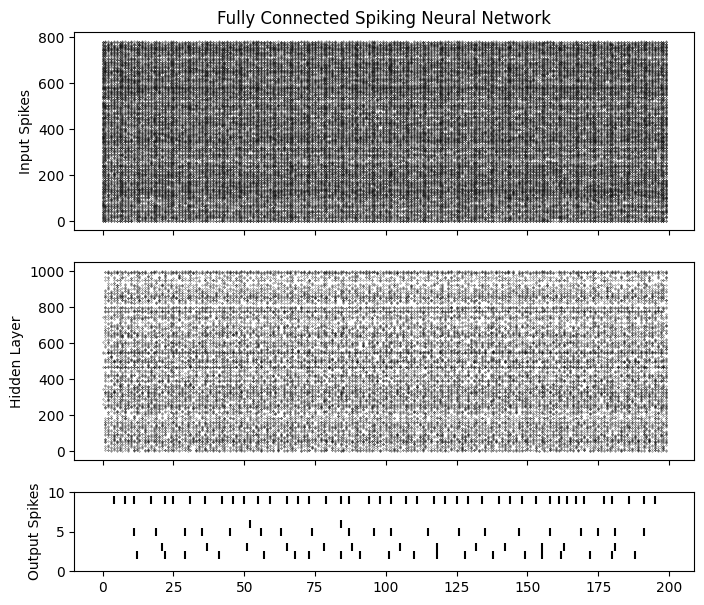

In [11]:
# network simulations
spk_in = spk_in.to(device)
spk1_rec, spk2_rec, mem2_rec  = net(spk_in)
plot_snn_spikes(spk_in, spk1_rec, spk2_rec, "Fully Connected Spiking Neural Network")

> If you run into errors, then try re-initializing your networks and parameters.


At this stage, the spikes don't have any real meaning. The inputs and weights are all randomly initialized, and no training has taken place. But the spikes  should appear to be propagating from the first layer through to the output. If you are not seeing any spikes, then you might have been unlucky in the weight initialization lottery - you might want to try re-running the last four code-blocks.

`spikeplot.spike_count` can create a spike counter of the output layer. The following animation will take some time to generate. <br>

> Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe



MovieWriter stderr:
ffmpeg: error while loading shared libraries: libopenh264.so.5: cannot open shared object file: No such file or directory



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x700', '-pix_fmt', 'rgba', '-r', '40.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpuw9w8ki0/temp.m4v']' returned non-zero exit status 127.

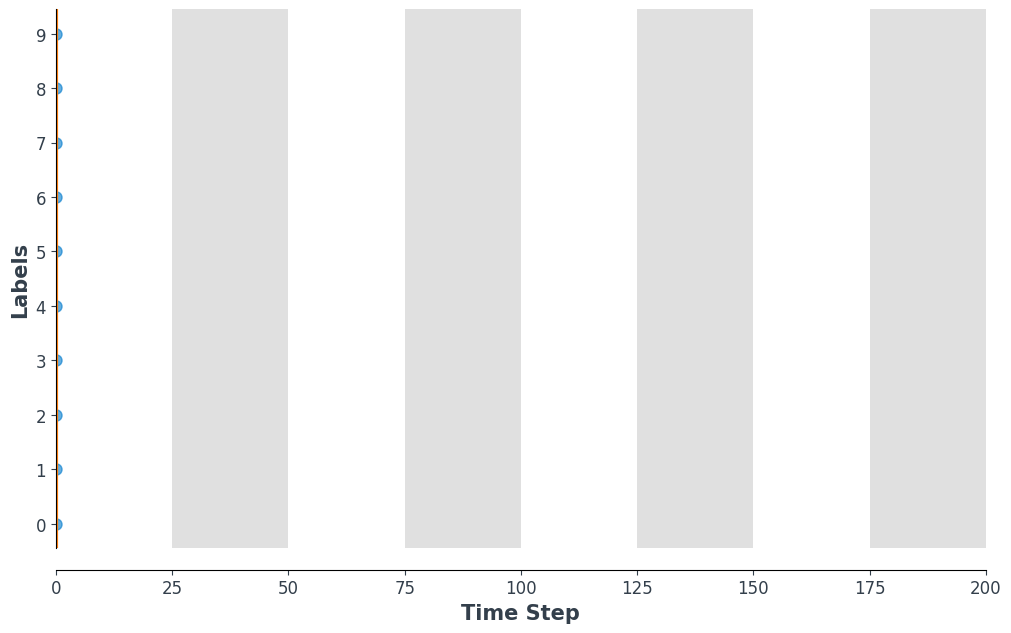

In [12]:
from IPython.display import HTML

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
spk2_rec = spk2_rec.squeeze(1).detach().cpu()

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk2_rec, fig, ax, labels=labels, animate=True)
HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

`spikeplot.traces` lets you visualize the membrane potential traces. We will plot 9 out of 10 output neurons.
Compare it to the animation and raster plot above to see if you can match the traces to the neuron.

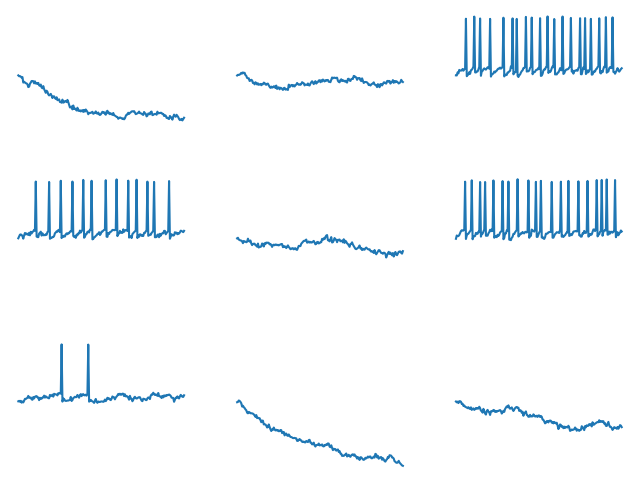

In [14]:
# plot membrane potential traces
mem2_rec = mem2_rec.to("cpu")
spk2_rec = spk2_rec.to("cpu")
splt.traces(mem2_rec.squeeze(1), spk=spk2_rec.squeeze(1))
fig = plt.gcf()
fig.set_size_inches(8, 6)

It is fairly normal if some neurons are firing while others are completely dead. Again, none of these spikes have any real meaning until the weights have been trained.